<a href="https://colab.research.google.com/github/ovbystrova/dpl/blob/master/notebooks/Language_model_exp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tokenizers

     |████████████████████████████████| 3.8MB 4.3MB/s 


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from tqdm import tqdm_notebook

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchtext.datasets import WikiText2
from torchtext import data

from tokenizers import SentencePieceBPETokenizer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [0]:
BATCH_SIZE = 64
MAX_SEQ_LENGTH = 40

In [4]:
!wget https://s3.amazonaws.com/research.metamind.io/wikitext/wikitext-2-v1.zip
!unzip 'wikitext-2-v1.zip'

--2020-05-05 07:19:36--  https://s3.amazonaws.com/research.metamind.io/wikitext/wikitext-2-v1.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.106.5
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.106.5|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4475746 (4.3M) [application/zip]
Saving to: ‘wikitext-2-v1.zip’

wikitext-2-v1.zip   100%[===================>]   4.27M  8.00MB/s    in 0.5s    

2020-05-05 07:19:37 (8.00 MB/s) - ‘wikitext-2-v1.zip’ saved [4475746/4475746]

Archive:  wikitext-2-v1.zip
   creating: wikitext-2/
  inflating: wikitext-2/wiki.test.tokens  
  inflating: wikitext-2/wiki.valid.tokens  
  inflating: wikitext-2/wiki.train.tokens  


In [0]:
def open_file(name):
    with open(name, 'r') as file:
        text = file.read()
    return text

def save_file(text, name):
    with open('/content/{}.txt'.format(name), 'w') as file:
        file.write(text)

def clean_data(text):
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'&[a-z]{0,7};', ' ', text)
    text = re.sub(r'\s{2,10}', ' ', text)
    text = re.sub(r'\s{2,10}', ' ', text)
    text = re.sub(r'\\\\x\d{1,4}', '', text)
    text = re.sub(r'=\s.{3,15}=\s', '', text)
    text = re.sub(r'\s@', ' ', text)
    text = re.sub(r'@\s', ' ', text)
    return text

def special_tokens(text):
    """
    Adds <eos> token if eos symbol occures.
    """
    eos = [' .', ' !', ' ?', ' ? !', ' \'n']
    eos_token = '<eos> <start>'
    for element in eos:
        text = text.replace(element, ' ' + eos_token + ' ')
    text = re.sub(r'<start>\s{2,10}<eos>', ' ', text)
    while '  ' in text:
        text = re.sub(r'\s{2,10}', ' ', text)
    text = '<start> ' + text
    return text

In [0]:
wiki_train = open_file('/content/wikitext-2/wiki.train.tokens')
wiki_train = clean_data(wiki_train)
wiki_train = special_tokens(wiki_train)
save_file(wiki_train, 'wiki_train')

wiki_valid = open_file('/content/wikitext-2/wiki.valid.tokens')
wiki_valid = clean_data(wiki_valid)
wiki_valid = special_tokens(wiki_valid)
save_file(wiki_train, 'wiki_valid')

In [7]:
wiki_valid[:150]

'<start>  = Homarus gammarus = Homarus gammarus , known as the European lobster or common lobster , is a species of <unk> lobster from the eastern Atla'

In [25]:
tokenize(wiki_train[200:350])

['<start>',
 '▁II',
 '▁outside',
 '▁Japan',
 '▁,',
 '▁is',
 '▁a',
 '▁tactical',
 '▁role',
 '▁-',
 '▁playing',
 '▁video',
 '▁game',
 '▁developed',
 '▁by',
 '▁Sega',
 '▁and',
 '▁Media',
 '.',
 'V',
 'ision',
 '▁for',
 '▁the',
 '▁PlayStation',
 '▁Portable',
 '▁',
 '<eos>',
 '▁',
 '<start>',
 '▁Released',
 '▁in',
 '▁J']

In [8]:
tokenizer = SentencePieceBPETokenizer()
tokenizer.train(['/content/wiki_train.txt', '/content/wiki_valid.txt'], special_tokens=['<eos>', '<unk>', '<start>'], vocab_size=30000)
tokenizer

Tokenizer(vocabulary_size=30000, model=SentencePieceBPE, unk_token=<unk>, replacement=▁, add_prefix_space=True, dropout=None)

In [0]:
def tokenize(text, tokenizer=tokenizer):
    text = clean_data(text)
    text = special_tokens(text)
    return tokenizer.encode(text).tokens

In [10]:
TEXT = data.Field(sequential=True, 
                  include_lengths=False, 
                  batch_first=True, 
                  tokenize=tokenize,
                  lower=True, 
                  pad_first=True)

train, valid, test = WikiText2.splits(TEXT)

TEXT.build_vocab(train, valid, unk_init = torch.Tensor.normal_, vectors='glove.6B.200d')
vocab = TEXT.vocab

print('Vocab size:', len(TEXT.vocab.itos))
TEXT.vocab.itos[:10]

downloading wikitext-2-v1.zip


wikitext-2-v1.zip: 100%|██████████| 4.48M/4.48M [00:00<00:00, 8.28MB/s]


extracting


.vector_cache/glove.6B.zip: 862MB [06:28, 2.22MB/s]                           
100%|█████████▉| 399213/400000 [00:33<00:00, 12172.98it/s]

Vocab size: 22825


['<unk>', '<pad>', '▁', '▁the', '<eos>', '<start>', '▁,', '▁of', '▁and', '▁in']

In [11]:
train_iterator, valid_iterator, test_iterator = data.BPTTIterator.splits(
    (train, valid, test),
    batch_size=BATCH_SIZE,
    bptt_len=MAX_SEQ_LENGTH,
    device=device,
    repeat=False, 
    shuffle=True)

b = next(iter(train_iterator)); vars(b).keys()

dict_keys(['batch_size', 'dataset', 'fields', 'text', 'target'])

In [12]:
TEXT.vocab.vectors.size()

torch.Size([22825, 200])

In [13]:
# PAD

pad_idx = TEXT.vocab.stoi['<pad>']
print('pad_idx', pad_idx)

pad_vec = TEXT.vocab.vectors[1]
print('pad_vec', pad_vec)

pad_idx 1
pad_vec tensor([-2.4661e-01,  9.5936e-01, -2.0439e+00, -1.3562e+00, -1.1020e-01,
        -2.0906e-02, -1.1450e+00,  6.2672e-01, -5.9613e-01,  4.1584e-02,
        -1.1577e+00, -1.6344e+00,  5.1698e-02, -4.7568e-01, -2.7345e+00,
         7.9180e-01, -1.4066e+00, -1.1240e+00, -6.3276e-02, -6.2490e-01,
        -1.4582e+00,  7.0818e-01, -3.8894e-01, -3.2830e-01, -3.9002e-01,
        -4.0174e-01,  1.4025e+00,  1.2130e+00,  1.3445e+00,  4.6408e-01,
        -4.8308e-01, -2.7499e+00,  5.5796e-01,  1.4275e+00, -1.0827e+00,
         1.4687e-01, -9.3323e-01, -6.5799e-01, -6.7275e-01,  1.1493e-01,
         6.0891e-01, -1.6092e+00,  1.2830e+00,  3.1124e-01,  1.6187e+00,
        -4.2354e-01,  1.4709e+00,  4.7389e-01,  1.3050e-01,  1.1839e+00,
         2.0282e+00, -4.3117e-01, -1.4223e+00,  8.8367e-01, -3.8330e-01,
         5.2150e-01,  1.0058e+00,  1.4640e+00,  1.6927e+00, -7.8877e-01,
        -4.9279e-02,  1.1397e+00,  1.3846e+00,  7.6454e-01,  1.3797e+00,
         6.3291e-01, -2.8601e-01,

In [0]:
class MyModel(nn.Module):
    
    def __init__(self, vocab_size, embed_size, hidden_size):
        super(MyModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        
        self.rnn = nn.LSTM(input_size=embed_size,
                           hidden_size=hidden_size,
                           bidirectional=True,
                           batch_first=True,
                          )
        
        self.fc = nn.Linear(hidden_size * 2, vocab_size)
        self.fc2 = nn.Linear(vocab_size, embed_size)
        
        self.init_weights()
        
    def init_weights(self):
        nn.init.uniform_(self.embedding.weight)
        nn.init.xavier_uniform_(self.fc.weight)
        nn.init.zeros_(self.fc.bias)
        
    def forward(self, batch):
        
        x = batch.text.T if hasattr(batch, 'text') else batch
        
        x = self.embedding(x)           
        x, _ = self.rnn(x)  # (bs,sq,hs)
        x = self.fc(x)  # (bs,sq,vocab_size)
        x = F.softmax(x, dim=-1)  # (bs,sq,vocab_size)
        x = self.fc2(x)  # (bs,sq,embed_size)
        return x

In [0]:
model = MyModel(vocab_size=len(TEXT.vocab.itos),
                embed_size=200,
                hidden_size=128,
               )
model.to(device)
model.embedding.weight.data.copy_(TEXT.vocab.vectors);

optimizer = optim.Adam(model.parameters())
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5)

criterion = nn.CrossEntropyLoss(ignore_index=1)
cosine = nn.CosineSimilarity(dim=-1)
mse = nn.MSELoss()
embed_y = nn.Embedding(len(TEXT.vocab.itos), 200).to(device)  
embed_y.weight.data.copy_(TEXT.vocab.vectors);

In [27]:
embed_y.weight.data, model.embedding.weight.data

(tensor([[ 0.0642,  0.5501,  0.5957,  ..., -0.2098,  0.6586,  0.6953],
         [-0.2466,  0.9594, -2.0439,  ...,  0.6445, -1.0314, -0.6709],
         [-0.0882, -0.2287, -0.6906,  ..., -2.8150,  2.0013,  1.0939],
         ...,
         [-1.2709, -0.5175,  1.3717,  ..., -1.2810, -0.1957, -0.1346],
         [-0.7931, -1.1528,  0.1254,  ...,  0.0163, -0.5839,  1.4611],
         [ 0.1575, -1.2098,  0.3678,  ...,  0.2879, -0.8884,  0.6602]],
        device='cuda:0'),
 tensor([[ 0.0642,  0.5501,  0.5957,  ..., -0.2098,  0.6586,  0.6953],
         [-0.2466,  0.9594, -2.0439,  ...,  0.6445, -1.0314, -0.6709],
         [-0.0882, -0.2287, -0.6906,  ..., -2.8150,  2.0013,  1.0939],
         ...,
         [-1.2709, -0.5175,  1.3717,  ..., -1.2810, -0.1957, -0.1346],
         [-0.7931, -1.1528,  0.1254,  ...,  0.0163, -0.5839,  1.4611],
         [ 0.1575, -1.2098,  0.3678,  ...,  0.2879, -0.8884,  0.6602]],
        device='cuda:0'))

In [0]:
def _train_epoch(model, iterator, optimizer, criterion, curr_epoch):

    model.train()

    running_loss = 0
    losses = []
    cosines = []

    n_batches = len(iterator)
    iterator = tqdm_notebook(iterator, total=n_batches, desc='epoch %d' % (curr_epoch), leave=True)

    for i, batch in enumerate(iterator):
        optimizer.zero_grad()

        pred = model(batch)
        y_emb = embed_y(batch.target.T)

        loss = mse(pred, y_emb)
        losses.append(loss.item())
        loss.backward()

        cosine_batch = (1- torch.mean(torch.mean(cosine(pred, y_emb)), dim=-1)).item()
        cosines.append(cosine_batch)
        
        optimizer.step()

        curr_loss = loss.data.cpu().detach().item()
        
        loss_smoothing = i / (i+1)
        running_loss = loss_smoothing * running_loss + (1 - loss_smoothing) * curr_loss

        iterator.set_postfix(loss='%.5f' % running_loss, cosine='%.5f' % cosine_batch)

    return running_loss, losses, cosines

In [0]:
def _test_epoch(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    losses = []
    cosines = []

    n_batches = len(iterator)
    with torch.no_grad():
        for batch in iterator:
            pred = model(batch)
            y_emb = embed_y(batch.target.T)
            loss = mse(pred, y_emb)
            losses.append(loss.item())
            epoch_loss += loss.data.item()

            cosine_batch = (1- torch.mean(torch.mean(cosine(pred, y_emb)), dim=-1)).item()
            cosines.append(cosine_batch)

    return epoch_loss / n_batches, losses, cosines

In [0]:
def nn_train(model, train_iterator, valid_iterator, criterion, optimizer, n_epochs=100,
          scheduler=None, early_stopping=0):

    model = model.to(device)
    criterion = criterion.to(device)
    
    prev_loss = 100500
    es_epochs = 0
    best_epoch = None
    history = pd.DataFrame()

    train_losses = []
    valid_losses = []
    train_cosines = []
    valid_cosines = []

    for epoch in range(n_epochs):
        train_loss, epoch_tl, epoch_tcosines = _train_epoch(model, train_iterator, optimizer, criterion, epoch)
        valid_loss,  epoch_vl, epoch_vcosines = _test_epoch(model, valid_iterator, criterion)
        
        train_losses.extend(epoch_tl)
        valid_losses.extend(epoch_vl)
        train_cosines.extend(epoch_tcosines)
        valid_cosines.extend(epoch_vcosines)

        print('validation loss %.5f' % valid_loss)

        record = {'epoch': epoch, 'train_loss': train_loss, 'valid_loss': valid_loss}
        history = history.append(record, ignore_index=True)

        if early_stopping > 0:
            if valid_loss > prev_loss:
                es_epochs += 1
            else:
                es_epochs = 0

            if es_epochs >= early_stopping:
                best_epoch = history[history.valid_loss == history.valid_loss.min()].iloc[0]
                print('Early stopping! best epoch: %d val %.5f' % (best_epoch['epoch'], best_epoch['valid_loss']))
                break

            prev_loss = min(prev_loss, valid_loss)
    return history, train_losses, valid_losses, train_cosines, valid_cosines

In [0]:
# class CosineSim(nn.Module): # TODO Ignore pad index?
#     def __init__(self, pad_idx):
#         super(CosineSime, self).__init__()


In [31]:
for el in train_iterator:
    x = el.text
    y = el.target.T
    print(x.size(), y.size())
    # print(x)
    # print(y)
    pred = model(el)#.transpose(1,2)
    # print('pred', pred.size())
    # print(criterion(pred, y))
    # cos = cosine()
    y_emb = embed_y(y)
    # print(y_emb.size())
    loss_mse = mse(pred, y_emb)
    print('mse', loss_mse)
    loss_cosine = cosine(pred, y_emb)
    print('cosine', loss_cosine.size())

    mean_cosine  = torch.mean(loss_cosine, dim=-1)
    mean_mean_cosine = torch.mean(mean_cosine)
    print(mean_cosine.size(), mean_mean_cosine.size())
    print(1-mean_mean_cosine)
    print(1- torch.mean(torch.mean(cosine(pred, y_emb)), dim=-1))
    break

torch.Size([40, 64]) torch.Size([64, 40])
mse tensor(0.9873, device='cuda:0', grad_fn=<MeanBackward0>)
cosine torch.Size([64, 40])
torch.Size([64]) torch.Size([])
tensor(0.9988, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.9988, device='cuda:0', grad_fn=<RsubBackward1>)


In [32]:
history, train_losses, valid_losses, train_cosines, valid_cosines = nn_train(model, train_iterator, valid_iterator, criterion, optimizer, scheduler=scheduler, 
        n_epochs=50, early_stopping=2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.



validation loss 0.70355



validation loss 0.66533



validation loss 0.65485



validation loss 0.62191



validation loss 0.61251



validation loss 0.60709



validation loss 0.60250



validation loss 0.59861



validation loss 0.59581



validation loss 0.58199



validation loss 0.57532



validation loss 0.57368



validation loss 0.57282



validation loss 0.57234



validation loss 0.57204



validation loss 0.57185



validation loss 0.57177



validation loss 0.57162



validation loss 0.57158



validation loss 0.57151



validation loss 0.55570



validation loss 0.54264



validation loss 0.54005



validation loss 0.52804



validation loss 0.52442



validation loss 0.52304



validation loss 0.52204



validation loss 0.52113



validation loss 0.52049



validation loss 0.52016



validation loss 0.51434



validation loss 0.51240



validation loss 0.51187



validation loss 0.50986



validation loss 0.50784



validation loss 0.50672



validation loss 0.50562



validation loss 0.50508



validation loss 0.50489



validation loss 0.50486



validation loss 0.50476



validation loss 0.50472



validation loss 0.50468



validation loss 0.50478



validation loss 0.50474
Early stopping! best epoch: 42 val 0.50468


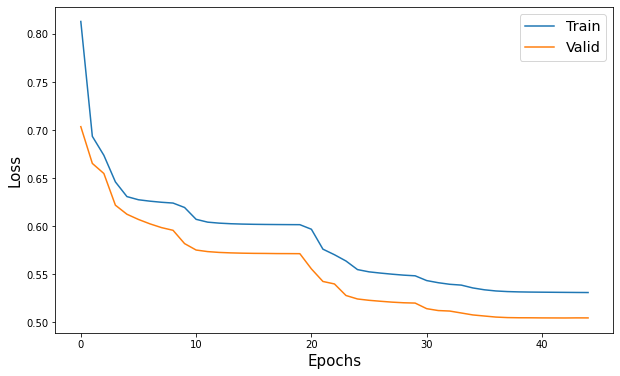

In [33]:
# Loss by epoch
plt.figure(figsize=(10,6))
plt.plot(np.arange(len(history['train_loss'])), history['train_loss'], label='Train')
plt.plot(np.arange(len(history['valid_loss'])), history['valid_loss'], label='Valid')
plt.xlabel('Epochs', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.legend(fontsize='x-large')
plt.show()

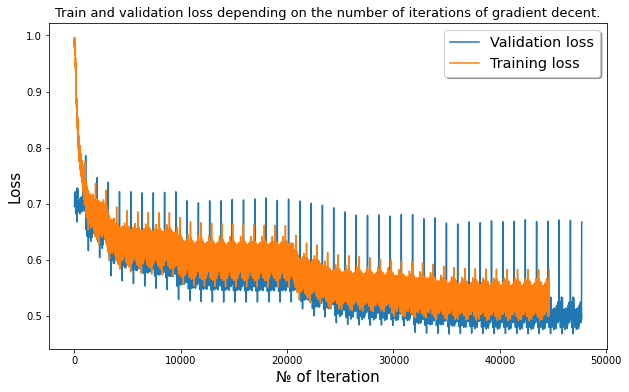

In [34]:
# Loss by iteration
new_val = [el for el in valid_losses for i in range(10)]
plt.figure(figsize=(10,6))
plt.plot(new_val, label='Validation loss')
plt.plot(train_losses, label='Training loss')
plt.ylabel('Loss', fontsize=15)
plt.xlabel('№ of Iteration', fontsize=15)
plt.title('Train and validation loss depending on the number of iterations of gradient decent.', fontsize=13)
plt.legend(fontsize='x-large', shadow=True)
plt.show()

In [35]:
embed_y.weight.data, model.embedding.weight.data

(tensor([[ 0.0642,  0.5501,  0.5957,  ..., -0.2098,  0.6586,  0.6953],
         [-0.2466,  0.9594, -2.0439,  ...,  0.6445, -1.0314, -0.6709],
         [-0.0882, -0.2287, -0.6906,  ..., -2.8150,  2.0013,  1.0939],
         ...,
         [-1.2709, -0.5175,  1.3717,  ..., -1.2810, -0.1957, -0.1346],
         [-0.7931, -1.1528,  0.1254,  ...,  0.0163, -0.5839,  1.4611],
         [ 0.1575, -1.2098,  0.3678,  ...,  0.2879, -0.8884,  0.6602]],
        device='cuda:0'),
 tensor([[ 0.0845,  0.2756,  0.5430,  ..., -0.7742,  0.5332,  0.4950],
         [ 0.3239,  0.8059, -1.8111,  ...,  0.7024, -0.5551, -0.6107],
         [-0.0512,  0.0088, -0.3402,  ..., -2.1427,  1.5480,  0.8389],
         ...,
         [-1.2446, -0.4660,  1.5273,  ..., -1.3442, -0.2218, -0.1814],
         [-0.7567, -1.1495,  0.1693,  ..., -0.0376, -0.6556,  1.3761],
         [ 0.1200, -1.3134,  0.4145,  ...,  0.3261, -0.8346,  0.8490]],
        device='cuda:0'))

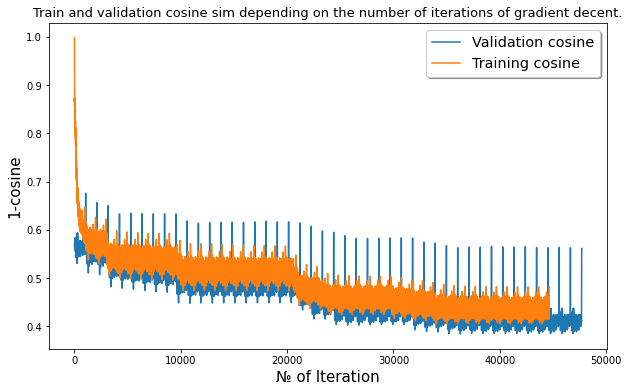

In [36]:
# 1-Cosine by iteration
new_cos = [el for el in valid_cosines for i in range(10)]
plt.figure(figsize=(10,6))
plt.plot(new_cos, label='Validation cosine')
plt.plot(train_cosines, label='Training cosine')
plt.ylabel('1-cosine', fontsize=15)
plt.xlabel('№ of Iteration', fontsize=15)
plt.title('Train and validation cosine sim depending on the number of iterations of gradient decent.', fontsize=13)
plt.legend(fontsize='x-large', shadow=True)
plt.show()

In [37]:
texts = [
         '<start>',
         'Test test test test test test test',
         '<eos>',
         'What is love',
         '▁', 
         'A ▁very ▁very ▁long ▁text',
         "And even longer text with ▁ symbol in the end ▁",
         'Who is',
         'It was a very sunny',
         'love is a', 
         'love is',
         'Homarus gammarus, known as the European', #lobster
         'russia is'
         ''
]

def predict(model, text, vocab, cosine=cosine, tokenize=tokenize):
    '''
    Finds the most similar token from vocab based on cosine sim

    text: input text (str)
    vocab: nn.Embedding layer of embed_y (vocab_size, embed_dim)

    '''

    tokenized = tokenize(text)
    ids = [TEXT.vocab.stoi[token] for token in tokenized]
    # print(ids)

    x = torch.tensor(ids).unsqueeze(0).to(device)
    # print(x.shape, x)

    with torch.no_grad():
        pred = model(x)
        cosines = cosine(pred[:,-1,:], vocab.weight.data)
        next_token_id = torch.argmax(cosines).item()
        next_token = TEXT.vocab.itos[next_token_id]
        # print(next_token)
        print(text + ' PREDICTION: ' + next_token)
    return
for text in texts:
    predict(model, text, embed_y)

<start> PREDICTION: <start>
Test test test test test test test PREDICTION: ▁the
<eos> PREDICTION: <start>
What is love PREDICTION: ▁"
▁ PREDICTION: <unk>
A ▁very ▁very ▁long ▁text PREDICTION: ▁in
And even longer text with ▁ symbol in the end ▁ PREDICTION: <eos>
Who is PREDICTION: ▁a
It was a very sunny PREDICTION: ▁was
love is a PREDICTION: ▁
love is PREDICTION: ▁a
Homarus gammarus, known as the European PREDICTION: ▁,
russia is PREDICTION: ▁a
